In [46]:
import yaml
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import json
from sklearn.cluster import KMeans
import umap.umap_ as umap
import scipy
import rasterio
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
import matplotlib.lines as mlines
import datetime
from osgeo import gdal, gdalconst
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist
from adjustText import adjust_text
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from adjustText import adjust_text
from scipy.ndimage import binary_erosion
from concurrent.futures import ThreadPoolExecutor
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Wedge
import copy
from matplotlib import font_manager as fm
from torchvision.transforms import ToTensor
import h5py
import feather
import cv2
import glob
import re
import matplotlib.lines as mlines

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False

In [47]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

## 會用到的函數

In [48]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
        
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance


# 計算兩個經緯度點之間的距離，支持向量化操作
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑，單位：公里
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c
def create_figure_mm(width_mm, height_mm, dpi=100):
    """
    根據毫米為單位的寬度和高度創建圖形
    :param width_mm: 寬度（以毫米為單位）
    :param height_mm: 高度（以毫米為單位）
    :param dpi: 圖形的分辨率（每英寸的點數）
    :return: fig, ax 圖形和軸對象
    """
    width_inch = width_mm / 25.4  # 將寬度從毫米轉換為英寸
    height_inch = height_mm / 25.4  # 將高度從毫米轉換為英寸
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
    return fig, ax
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
def get_chinese_sciname(target_name):
    change_names = {
    'Anas_zonorhyncha': 'Anas_poecilorhyncha', 
    'Cyanoderma_ruficeps': 'Stachyridopsis_ruficeps', 
    'Erythrogenys_erythrocnemis': 'Pomatorhinus_erythrocnemis', 
    'Ictinaetus_malaiensis': 'Ictinaetus_malayensis', 
    'Lewinia_striata': 'Gallirallus_striatus', 
    'Machlolophus_holsti': 'Parus_holsti', 
    'Pterorhinus_poecilorhynchus': 'Garrulax_poecilorhynchus', 
    'Pterorhinus_ruficeps': 'Garrulax_ruficeps', 
    'Schoeniparus_brunneus': 'Alcippe_brunnea', 
    'Sittiparus_castaneoventris': 'Poecile_varius', 
    'Synoicus_chinensis': 'Coturnix_chinensis', 
    'Taenioptynx_brodiei': 'Glaucidium_brodiei', 
    'Tarsiger_formosanus': 'Tarsiger_indicus', 
    'Turdus_niveiceps': 'Turdus_poliocephalus', 
    'Zapornia_fusca': 'Porzana_fusca'
    }
    df_name = pd.read_csv('../2023臺灣鳥類名錄-20230419.csv')
    for (new_name, orig_name) in change_names.items():
        if target_name == orig_name:
            target_name = new_name
            
    df_target = df_name[df_name['學名'] == target_name.replace('_', ' ')]
    return df_target['中文名'].values[0]
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

In [112]:
# create a plot folder of the specific exp_id
plot_path = os.path.join('plots', run_id)
plot_path_FigS1_trainvalidationsplit = os.path.join(plot_path, 'FigS1_trainvalidationsplit')
create_folder(plot_path_FigS1_trainvalidationsplit)
plot_path_df = os.path.join(plot_path, 'Fig4_dataframe')
plot_path_nichespace = os.path.join(plot_path, 'Fig4_niche_space')
plot_path_ecogeo_basedonDeepSDMpred = os.path.join(plot_path, 'Fig6_EcoGeo_comparison_basedonDeepSDMpred')
plot_path_biotop = os.path.join(plot_path, 'Fig6_biotop')
plot_path_subplots = os.path.join(plot_path, 'Fig6_subplots')
plot_path_nichespace_h5 = os.path.join(plot_path_nichespace, 'h5')

In [50]:
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
with open(os.path.join(predicts_path, 'DeepSDM_conf.yaml'), 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))

with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

with open(os.path.join(predicts_path, 'env_inf.json'), 'r') as f:
    env_inf = json.load(f)
    
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    extent_binary = f.read(1)
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    crs = f.crs
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    extent_binary = f.read(1)
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]

In [51]:
deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [52]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])
date_list_train = DeepSDM_conf.training_conf['date_list_train']
date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
env_list = DeepSDM_conf.training_conf['env_list']

In [53]:
with open(os.path.join(plot_path_df, 'extent_info.yaml'), 'rb') as f:
    extent_info = yaml.load(f, yaml.FullLoader)
df_grid = feather.read_dataframe(os.path.join(plot_path_df, 'df_grid.feather'))
df_env_value = feather.read_dataframe(os.path.join(plot_path_df, 'env_value.feather'))
df_spearman_pre = pd.read_csv(os.path.join(plot_path_nichespace, 'spearman_info_basedonDeepSDMpred.csv'))

# table

In [5]:
# 1. 讀取遮罩檔 (extent_binary.tif)
extent_path = './workspace/extent_binary.tif'
with rasterio.open(extent_path, 'r') as f:
    extent_binary = f.read(1)

destination = gdal.Open(extent_path)
dst_transform = destination.GetGeoTransform()
dst_projection = destination.GetProjection()
dst_xsize = destination.RasterXSize
dst_ysize = destination.RasterYSize

# 2. 找出 /work/klok0126/landcover 資料夾中的所有 nc 檔案
nc_folder = '/work/klok0126/landcover'
nc_files = glob.glob(os.path.join(nc_folder, '*.nc'))

results = []  # 用來存放每個檔案的統計結果

# 3. 處理每個 nc 檔案
for nc_file in nc_files:
    # 建立 GDAL 讀取子資料集的字串，此處讀取 "lccs_class" 層
    dataset_path = f'NETCDF:{nc_file}:lccs_class'
    src_nc = gdal.Open(dataset_path, gdalconst.GA_ReadOnly)
    if src_nc is None:
        print(f"無法開啟檔案 {nc_file}")
        continue
    src_proj = src_nc.GetProjection()

    # 建立臨時輸出檔 (可用 /tmp/temp.tif 或使用 vsimem)
    temp_tif = '/tmp/temp.tif'
    dst_driver = gdal.GetDriverByName('GTiff')
    dst_tif = dst_driver.Create(temp_tif, dst_xsize, dst_ysize, 1, gdalconst.GDT_Int32)
    dst_tif.SetGeoTransform(dst_transform)
    dst_tif.SetProjection(dst_projection)

    # 重投影：從 src_nc 重投影到 dst_tif
    gdal.ReprojectImage(src_nc, dst_tif, src_proj, dst_projection, gdalconst.GRA_Mode)


    # 讀取重投影後的陣列
    reprojected = dst_tif.GetRasterBand(1).ReadAsArray()

    # 根據 extent_binary 做遮罩：extent_binary==0 的位置設為 nan，其餘保留重投影後的值
    # （假設 extent_binary 為 0 表示無效區域）
    landcovervalue = np.where(extent_binary == 0, np.nan, reprojected)

    # 統計各 landcover 類別的像元數量（忽略 nan）
    unique_vals, counts = np.unique(landcovervalue[~np.isnan(landcovervalue)], return_counts=True)
    # 將 unique 值轉為 int，並組成字典
    count_dict = {int(val): int(cnt) for val, cnt in zip(unique_vals, counts)}

    # 將結果儲存，並記錄來源檔名
    results.append({
        'filename': os.path.basename(nc_file),
        'counts': count_dict
    })

    # 清理釋放資源
    dst_tif = None
    dst_driver = None
    src_nc = None
    # 移除臨時檔案
    if os.path.exists(temp_tif):
        os.remove(temp_tif)

# 4. 將所有檔案的統計結果存成 JSON 檔案
output_json = 'landcover_counts.json'
# with open(output_json, 'w') as f:
#     json.dump(results, f, indent=2)

print("統計結果已存到", output_json)


統計結果已存到 landcover_counts.json


In [42]:
total_counts = {}

for item in results:
    # 從檔名中抓取年份
    match = re.search(r'P1Y-(\d{4})', item['filename'])
    if match:
        year = int(match.group(1))
        # 只處理 2009 至 2018 年的數據
        if 2009 <= year <= 2018:
            for key, count in item['counts'].items():
                total_counts[key] = total_counts.get(key, 0) + count

print(total_counts)

print({key:(total_counts[key]/sum(list(total_counts.values()))) for key in total_counts})

{10: 77674, 11: 46151, 12: 677, 20: 65780, 30: 32901, 40: 12682, 50: 506418, 70: 540, 80: 66, 100: 28, 120: 62, 130: 90, 150: 505, 160: 999, 170: 2835, 180: 6759, 190: 38147, 210: 4498, 110: 8}
{10: 0.09747998293215532, 11: 0.05791897793730077, 12: 0.0008496272683918576, 20: 0.08255314876634623, 30: 0.041290379257548755, 40: 0.015915765166536984, 50: 0.6355488065058608, 70: 0.0006776938329861198, 80: 8.282924625385909e-05, 100: 3.513968022890992e-05, 120: 7.780929193544339e-05, 130: 0.00011294897216435331, 150: 0.0006337692326999824, 160: 0.0012537335910243216, 170: 0.0035578926231771293, 180: 0.008482467809542933, 190: 0.04787404934615095, 210: 0.005644938631058458, 110: 1.0039908636831405e-05}


In [ ]:
{10: 0.09747998293215532, 
 11: 0.05791897793730077, 
 12: 0.0008496272683918576, 
 20: 0.08255314876634623, 
 30: 0.041290379257548755, 
 40: 0.015915765166536984, 
 50: 0.6355488065058608, 
 70: 0.0006776938329861198, 
 80: 8.282924625385909e-05, 
 100: 3.513968022890992e-05, 
 120: 7.780929193544339e-05, 
 130: 0.00011294897216435331, 
 150: 0.0006337692326999824, 
 160: 0.0012537335910243216, 
 170: 0.0035578926231771293, 
 180: 0.008482467809542933, 
 190: 0.04787404934615095, 
 210: 0.005644938631058458, 
 110: 1.0039908636831405e-05}

# Figure

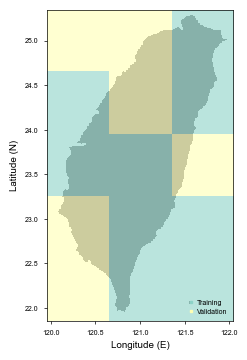

In [114]:
partition_file='./workspace/partition.txt'
spatial_conf = SimpleNamespace(**DeepSDM_conf.spatial_conf_tmp)
train_val_partitions = np.loadtxt(partition_file, delimiter=',')
train_val_mask = cv2.resize(train_val_partitions, (spatial_conf.num_of_grid_x * spatial_conf.grid_size, spatial_conf.num_of_grid_y * spatial_conf.grid_size), interpolation=cv2.INTER_NEAREST)


fig, ax = plt.subplots(figsize = mm2inch(40, 100), constrained_layout = True)
ax.imshow(np.where(extent_binary == 0, np.nan, extent_binary), extent = extent_binary_extent, cmap = ListedColormap('grey'))
ax.imshow(train_val_mask, alpha = 0.6, cmap = ListedColormap(['#ffffb3', '#8dd3c7']), extent = extent_binary_extent)
ax.set_xlabel('Longitude (E)')
ax.set_ylabel('Latitude (N)')

# 建立代理對象
validation_proxy = mlines.Line2D([], [], color='#ffffb3', marker='s', linestyle='None', markersize=2, label='Validation')
training_proxy = mlines.Line2D([], [], color='#8dd3c7', marker='s', linestyle='None', markersize=2, label='Training')

ax.legend(handles=[training_proxy, validation_proxy], loc='lower right', handletextpad=-0.2)
plt.savefig(os.path.join(plot_path_FigS1_trainvalidationsplit, 'train_validation_split.pdf'), dpi = 500, transparent = True)
plt.show()